The code imports necessary libraries, including TensorFlow, PIL (Python Imaging Library), NumPy, and others

In [92]:
# Import necessary libraries
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [93]:
# Set random seed
tf.random.set_seed(272)
# format the printing to improve readability
pp = pprint.PrettyPrinter(indent=4)
img_size = 400

### Load the VGG model 

In [94]:
# Load VGG19 model with pretrained weights
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')
vgg.trainable = False
pp.pprint(vgg)

Here, we will display the content image

The content image (C) shows my profile picture.


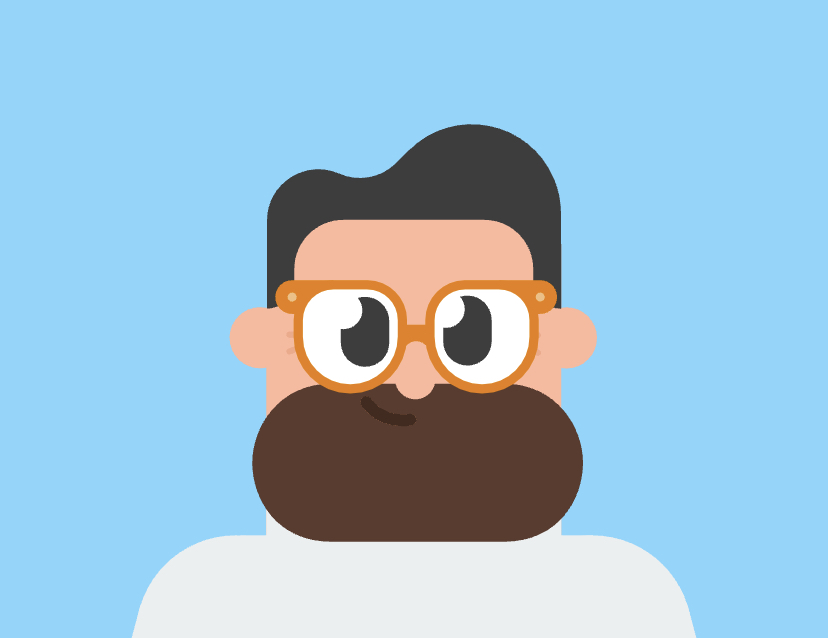

In [95]:
# Load and display content image
content_image = Image.open("images/content.jpg")
print("The content image (C) shows my profile picture.")
content_image

## Neural Style Transfer (NST)

We will be building the Neural Style Transfer (NST) algorithm in three steps:

- First, build the content cost function $J_{content}(C,G)$
- Second, build the style cost function $J_{style}(S,G)$
- Finally, put it all together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$.

### Compute the content cost

After implementing the NST algorithm we expect the content in generated image G to match the content of image C. A method to achieve this is to calculate the content cost function, which will be defined as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer chosen, and appear in a normalization term in the cost. 
* note that $a^{(C)}$ and $a^{(G)}$ are the 3D volumes corresponding to a hidden layer's activations. 
* in order to compute the cost $J_{content}(C,G)$, it might also be convenient to unroll these 3D volumes into a 2D matrix.


In [96]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    
    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.shape
    
    # Reshape 'a_C' and 'a_G'
    a_C_unrolled = tf.reshape(a_C, shape=[1, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[1, -1, n_C])
    
    # compute the cost with tensorflow
    J_content = (1/(4*n_H*n_W*n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
  
    return J_content

Display the style picture

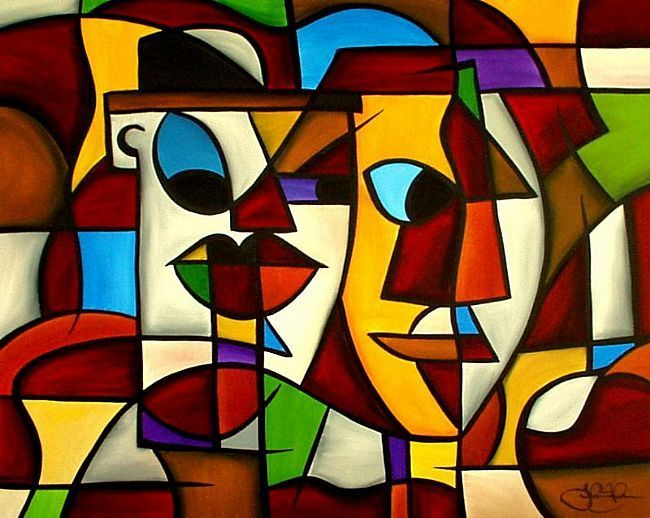

In [97]:
# Load and display an example image
example = Image.open("images/style.jpg")
example

### Style Matrix

#### Understanding the Gram Matrix
* The style matrix, often referred to as the "Gram matrix," plays a pivotal role in Neural Style Transfer.
* In mathematical terms, the Gram matrix is represented as $G_{(gram)ij}$, where it captures correlations between features.

#### Interpretation of Correlation
The Gram matrix provides valuable insights into how different features within an image correlate with each other. Specifically:
* The entry $G_{(gram)i,j}$ in the Gram matrix reflects the extent of similarity between the activations of filter $i$ and those of filter $j$.
* This measure helps us understand how distinct features interact and combine within the image.

#### Unveiling Feature Prevalence
Notably, the diagonal elements $G_{(gram)ii}$ of the Gram matrix hold significant meaning:
* These elements shed light on the "activity" level of a specific filter $i$.
* To illustrate, let's say filter $i$ is designed to identify vertical textures in the image. In this case, $G_{(gram)ii}$ reveals the prevalence of vertical textures across the entire image.
* If $G_{(gram)ii}$ is substantial, it signifies that vertical textures are abundant in the image.

#### Capturing Style Characteristics
By encapsulating both the occurrence frequency of different feature types ($G_{(gram)ii}$) and the way various features coexist ($G_{(gram)ij}$), the Gram matrix ($G_{gram}$) effectively quantifies an image's style attributes.

In [98]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """  
    
    GA = tf.matmul(A, tf.transpose(A))

    return GA

### Style Cost Function

next we will minimize the distance between the Gram matrix of the "style" image S and the Gram matrix of the "generated" image G. 
* For now, we will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.

In [99]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.shape.as_list()
    
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W)
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer =  (1 / (4 * n_C * n_C * n_H * n_W * n_H * n_W)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    return J_style_layer

### Style Layers to choose
Now, we will pick the layers

In [100]:
# Print layer names in the VGG19 model
for layer in vgg.layers:
    print(layer.name)

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [101]:
# Print the output of a specific layer in the VGG19 model
vgg.get_layer('block5_conv4').output

<KerasTensor: shape=(None, 25, 25, 512) dtype=float32 (created by layer 'block5_conv4')>

Choose layers to represent the style of the image and assign style costs

In [102]:
# Define style layers and their weights
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

### Style cost for multiple layers

combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


In [103]:
def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

## Total Cost 
Define a function to compute the total cost

Note: the `@tf.function` is a decorator in TensorFlow that converts Python functions into optimized TensorFlow computation graphs, improving performance by leveraging graph execution and optimization techniques. It's commonly used to speed up and optimize the execution of TensorFlow code.

In [104]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

### Preprocess the content and style pictures

(1, 400, 400, 3)


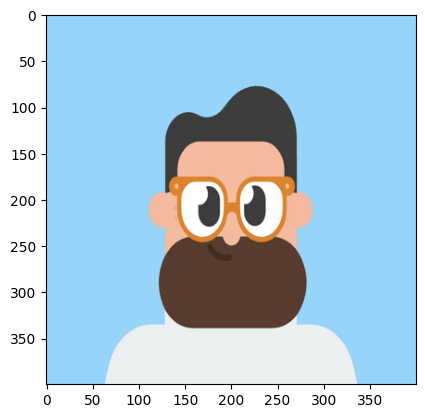

In [105]:
# Load, preprocess, and display content image
content_image = np.array(Image.open("images/content.jpg").resize((img_size, img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))
print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


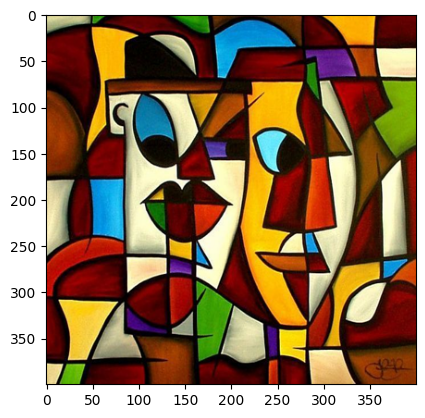

In [106]:
# Load, preprocess, and display style image
style_image =  np.array(Image.open("images/style.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
print(style_image.shape)
imshow(style_image[0])
plt.show()

### Randomly Initialize the Image to be Generated
Now, we will initialize the "generated" image as a noisy image created from the content_image

(1, 400, 400, 3)


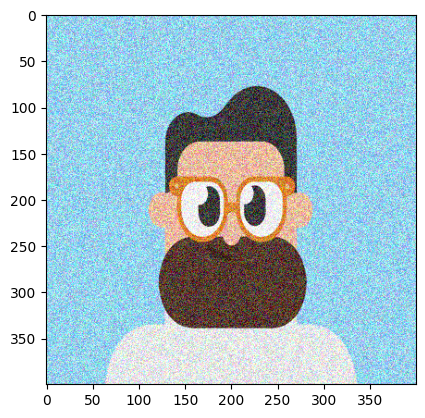

In [107]:
# Initialize the generated image with content image and add noise
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

A function get_layer_outputs() is defined to get intermediate layer outputs from the VGG model.

In [108]:
# Define a function to get intermediate layer outputs from the VGG model
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [109]:

# Define content and style layers
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer) # create the model 
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

The content and style images are encoded using the VGG model to obtain activations

In [110]:
# Encode content image and style image using the VGG model
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

Functions are defined to clip tensor values between 0 and 1 and to convert tensors to PIL images.

In [111]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    
    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

Define an optimizer for training

In [112]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

Implement the train_step() function for transfer learning

In [113]:
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function we must use the precomputed encoded images a_S and a_C
    
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)
        
        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G, STYLE_LAYERS=STYLE_LAYERS)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)

        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 40)
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return J

In [114]:
generated_image = tf.Variable(generated_image)

Train the model and show generated images at some epochs

Epoch 0 


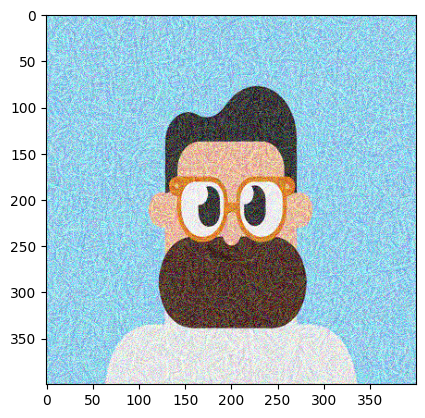

Epoch 250 


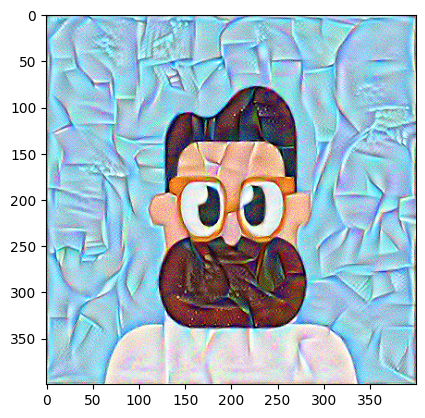

Epoch 500 


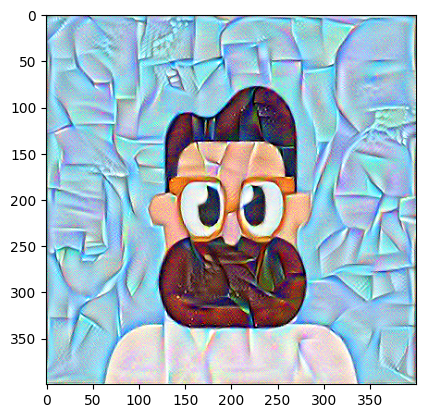

Epoch 750 


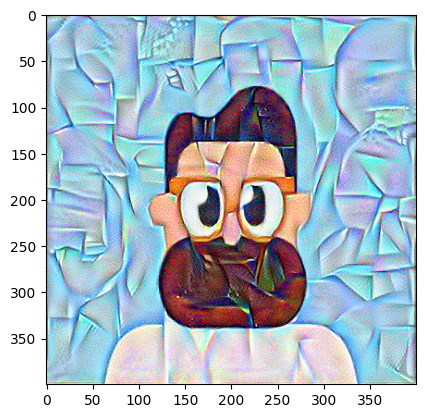

Epoch 1000 


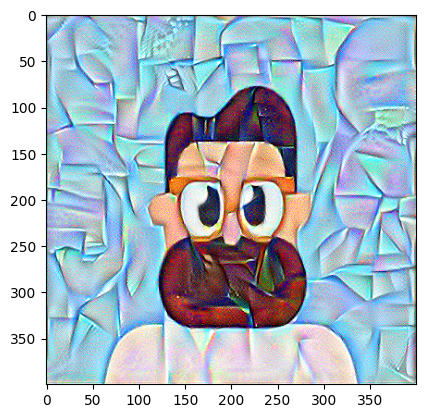

Epoch 1250 


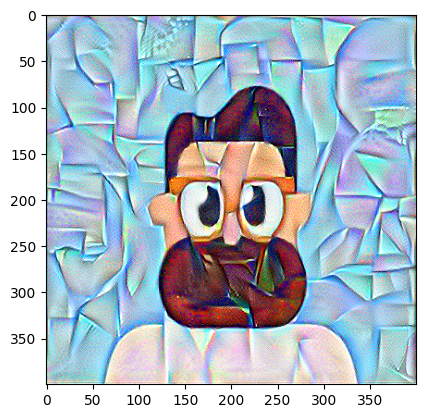

Epoch 1500 


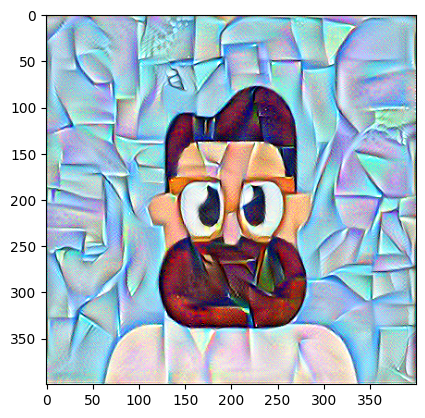

Epoch 1750 


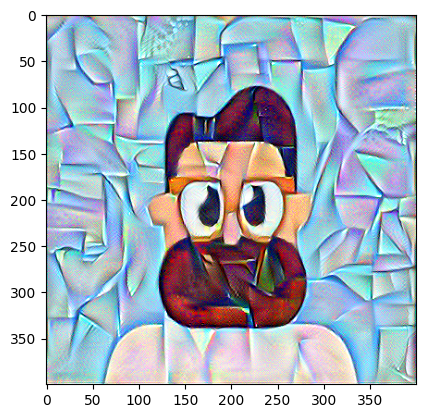

Epoch 2000 


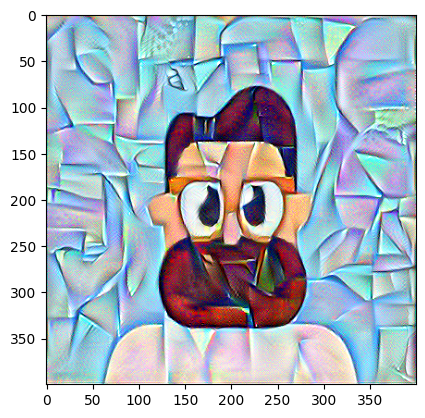

Epoch 2250 


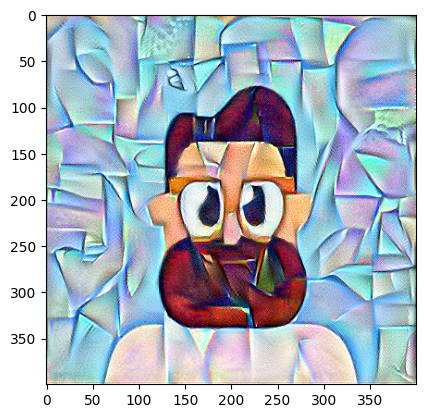

Epoch 2500 


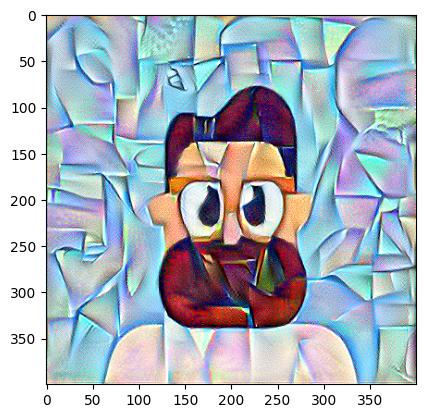

In [116]:
epochs = 2501
for i in range(epochs):
    train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show() 

save the final image

In [117]:
image.save(f"output/image_{i}.jpg")

display the final output

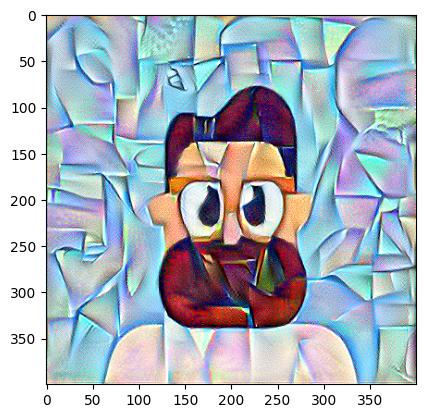

In [118]:
imshow(image)